In [112]:
%matplotlib inline

--------
Neural Networks
===============
PyTorch provides the elegantly designed modules and classes ``torch.nn`` , ``torch.optim`` , ``Dataset`` , and ``DataLoader`` to help you create and train neural networks.

-  **torch.nn**: a neural net library with common layers and cost functions
-  **torch.autograd**: a package for building a computational graph and automatically obtaining gradients
-  **torch.optim**: an optimization package with common optimization algorithms like SGD,Adam, etc
-  **Dataset**: an abstract class representing a dataset
-  **DataLoader**: combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset

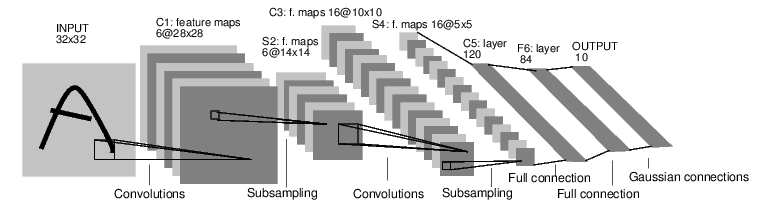

A typical training procedure for a neural network is as follows:

1.  Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``




---
## Autograd: Automatic Differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors.


``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.

Create a tensor and set ``requires_grad=True`` to track computation with it


In [113]:
import torch
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.

Do more operations on ``y``

In [114]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward1>)


``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.

In [115]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


### Gradients

Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.

In [116]:
out.backward()

Print gradients d(out)/dx

In [117]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad=True`` by wrapping the code block in
``with torch.no_grad():``

In [118]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print(x.requires_grad)
    print((x ** 2).requires_grad)

True
True
True
False


--------
1- Define the network
------------------

Let’s define this network:

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 14 * 14, 120)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
# print(net)

In [120]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.1264,  0.1328, -0.4482, -0.3536, -0.1186, -0.0948, -0.4982, -0.4228,
          0.1865, -0.0433]], grad_fn=<AddmmBackward>)


--------
Important Members of ``torch.nn``
=========
**Convolution layers: conv1d, conv2d, conv3d** with variabling including ``weight`` and ``bias``.
-  in_channels
-  out_channels
-  kernel_size
-  stride=1
-  padding=0
-  dilation=1
-  groups=1
-  bias=True

In [121]:
m = nn.Conv1d(in_channels=16, out_channels=33, kernel_size=3, stride=1, padding=0)
input = torch.randn(20, 16, 60)
output = m(input)
print(output.size())

torch.Size([20, 33, 58])


In [122]:
m = nn.Conv2d(in_channels=16, out_channels=33, kernel_size=3, stride=2)
input = torch.randn(20, 16, 50, 100)
output = m(input)
print(output.size())

torch.Size([20, 33, 24, 49])


**Pooling layers: MaxPool1d, MaxPool2d, MaxPool3d, etc**
-  kernel_size
-  stride
-  padding=0
-  dilation=1

In [123]:
m = nn.MaxPool2d((3, 3), stride=(2, 2))
input = torch.randn(20, 16, 50, 32)
output = m(input)
print(output.size())

torch.Size([20, 16, 24, 15])


**Activation functions: Relu, Sigmoid, Tanh**

In [124]:
m = nn.ReLU()
input = torch.randn(2)
output = m(input)
print(output)

tensor([0., 0.])


**Recurrent layers: RNN, LSTM, GRU**
<br>
Apply a multi-layer RNN to an input sequence with variables weight_ih_l, weight_hh_l, bias_ih_l, bias_hh_l
-  input_size
-  hidden_size
-  num_layers
-  bias
-  batch_first
-  dropout
-  bidirectional

$\mathbf{h_t = \phi(Wx_t + b_{W} + Uh_{t-1} + b_{U})}$

In [125]:
nlayers = 1
rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=nlayers)
input = torch.randn(5, 3, 10)
h0 = torch.randn(nlayers, 3, 20)
output, hn = rnn(input, h0)

for parameter in rnn.parameters():
    print(parameter.size())

torch.Size([20, 10])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])


In [126]:
nlayers = 1
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=nlayers)
input = torch.randn(5, 3, 10)
h0 = torch.randn(nlayers, 3, 20)
c0 = torch.randn(nlayers, 3, 20)
output, (hn, cn) = lstm(input, (h0, c0))
# print(output)

for parameter in lstm.parameters():
    print(parameter.size())

torch.Size([80, 10])
torch.Size([80, 20])
torch.Size([80])
torch.Size([80])


**Normalization layers: BatchNorm1d, BatchNorm2d, BatchNorm3d**

Apply Batch Normalization over the input


In [127]:
m = nn.BatchNorm2d(100)
input = torch.randn(20, 100, 35, 45)
output = m(input)
print(output.size())

torch.Size([20, 100, 35, 45])


**Dropout layers: Dropout, Dropout1d, Dropout2d**

During training, randomly zero some of the elements of the input tensor

In [128]:
m = nn.Dropout(p=0.5)
input = torch.randn(2,8)
print(input)
output = m(input)
print(output)

tensor([[-1.4636, -0.9831, -1.2707,  0.4536, -0.9529,  0.7225, -0.1948, -0.8190],
        [ 0.1029, -0.4624,  1.4359, -1.3221,  1.5005,  0.8177,  0.2343, -0.1604]])
tensor([[-0.0000, -1.9662, -0.0000,  0.0000, -1.9057,  1.4450, -0.0000, -0.0000],
        [ 0.2057, -0.9249,  0.0000, -2.6442,  0.0000,  1.6354,  0.0000, -0.0000]])


**Embedding**: A simple lookup table that stores embeddings of a fixed dictionary and size with parameter W.
-  num_embeddings
-  embedding_dim

In [129]:
# an Embedding module containing 1000 tensors of size 3
embedding = nn.Embedding(1000, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,21,437,80],[999,32,21,10]])
embedding(input)


tensor([[[-0.4362,  1.7213, -0.1511],
         [ 0.4780, -2.0271, -0.7997],
         [ 0.1330, -1.3517, -0.6273],
         [ 0.9894,  1.3420,  0.0236]],

        [[ 0.5241, -0.0358, -0.5572],
         [ 0.0849, -0.0175, -1.7368],
         [ 0.4780, -2.0271, -0.7997],
         [-0.2749, -0.4670, -0.7746]]], grad_fn=<EmbeddingBackward>)

**Linear layers**
<br>
Apply a linear transformation to the incoming data: $y = xA^T + b$ with variables including ``weight`` and ``bias``.
-  in_features
-  out_features
-  bias=True

In [130]:
m = nn.Linear(in_features=20, out_features=30)
input = torch.randn(128, 20)
output = m(input)

for parameter in m.parameters():
    print(parameter.size())

print(output.size())

torch.Size([30, 20])
torch.Size([30])
torch.Size([128, 30])


**Sequential**:
<br>
Modules will be added to it in the order they are passed in the constructor <br>

In [131]:
# Example of using Sequential
model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

for parameter in model.parameters():
    print(parameter.size())



torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([64, 20, 5, 5])
torch.Size([64])


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NetSeq(nn.Module):

    def __init__(self):
        super(NetSeq, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        #self.relu1 = nn.ReLU()
        #self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
            )

        self.lin = nn.Sequential( 
            nn.Linear(16 * 14 * 14, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
            )
            
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.lin(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net2 = NetSeq()
# print(net)

2- Iterate over a dataset of inputs
-----------

There is a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, MNIST, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this tutorial, we will use the MNIST dataset.
It has the classes: ‘zero’, ‘one’, ‘two’, ‘three’, ‘four’,
‘five’, ‘six’, ‘seven’, ‘eight’, ‘nine’. The images in trainset are of
size 1x28x28, i.e. 1-channel images of 28x28 pixels in size.

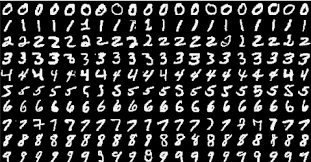


**Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``**

In [133]:
import torch
import torchvision
import torchvision.transforms as transforms

[Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) are common image transformations.

They can be chained together using ``Compose``. 

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [134]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Let us show some of the training images, for fun.

Text(0.5, 1.0, '5')

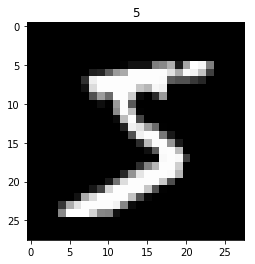

In [135]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(trainset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % trainset.train_labels[0])


A detailed example on building a custom dataset can be found [here](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

We can also utilize ``ImageFolder`` to load data from a directory where the images are arranged in this way:

root/class1/xxx.png
<br>
root/class1/xxy.png
<br>
root/class1/xxz.png
<br>
<br>
root/class2/123.png
<br>
root/class2/nsdf3.png
<br>
root/class2/asd932_.png

In [136]:
train_dataset = datasets.ImageFolder(root='my_data/train',
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

test_dataset = datasets.ImageFolder(root='my_data/train',
                                           transform=data_transform)
test_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

NameError: name 'datasets' is not defined

3- Process input through the network
---------

In [137]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.1209,  0.0337, -0.3535, -0.3191,  0.0460, -0.1952, -0.3408, -0.3036,
          0.1381, -0.1035]], grad_fn=<AddmmBackward>)


<div class="alert alert-info"><h4>Note</h4><p>torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not
    a single sample.
For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.

If you have a single sample, just use input.unsqueeze(0) to add
a fake batch dimension.</p></div>


4- Compute the Loss
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

-  MSELoss
-  NLLLoss
-  CrossEntropyLoss



In [138]:
input = torch.randn(1, 1, 28, 28)
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output

criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(0.9672, grad_fn=<MseLossBackward>)


In [139]:
criterion = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss = criterion(input, target)
print(loss)

tensor(2.2619, grad_fn=<NllLossBackward>)


<div class="alert alert-info">
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d    
          -> view -> linear -> relu -> linear -> relu -> linear          
          -> MSELoss          
          -> loss
</div>


5- Propagate Gradients Back into the Parameters
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [147]:
net = Net()
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

6- Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

 ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

In [151]:
net = Net()
input = torch.randn(1, 1, 28, 28)
out = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()
loss = criterion(output, target)
net.zero_grad()
net.zero_grad().backward()
print(out)


learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad * learning_rate)


tensor([[ 0.1474,  0.2295, -0.0440,  0.0013,  0.0883,  0.0031, -0.0614,  0.0603,
          0.0044, -0.0445]], grad_fn=<AddmmBackward>)
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>


However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, there is a small package: ``torch.optim`` that
implements all these methods. 

-  ``SGD``
	-  params
	-  lr=0.001
	-  weight_decay=0
	-  momentum=0
	-  nesterov=False
-  ``Adam``
	-  params
	-  lr=0.001
	-  weight_decay=0






Using it is very simple:

In [93]:
import torch.optim as optim

input = torch.randn(3, 1, 28, 28)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
print(net.conv1.bias)
optimizer.step()    # Does the update
print(net.conv1.bias)


Parameter containing:
tensor([ 0.0644, -0.0832, -0.1980, -0.0102,  0.0436, -0.1631, -0.1385, -0.0557,
        -0.1385, -0.0440,  0.0331,  0.1159, -0.1167,  0.1442,  0.1594, -0.0925],
       requires_grad=True)
Parameter containing:
tensor([ 0.0724, -0.0800, -0.1937, -0.0031,  0.0482, -0.1579, -0.1360, -0.0523,
        -0.1341, -0.0405,  0.0400,  0.1200, -0.1132,  0.1531,  0.1665, -0.0862],
       requires_grad=True)


**How to Adjust Learning Rate**

There are two types of scheduling for this purpose:

-  ``torch.optim.lr_scheduler`` provides several methods to adjust the learning rate based on the number of epochs. 
-  ``torch.optim.lr_scheduler.ReduceLROnPlateau`` allows dynamic learning rate reducing based on some validation measurements.

Differet options to shedule the learning rate:

-  ``torch.optim.lr_scheduler.LambdaLR``:
-  ``torch.optim.lr_scheduler.StepLR``:
-  ``torch.optim.lr_scheduler.MultiStepLR``:
-  ``torch.optim.lr_scheduler.ReduceLROnPlateau``:

In [95]:
# Assuming optimizer has two groups.
# lambda1 = lambda epoch: epoch // 30
# lambda2 = lambda epoch: 0.95 ** epoch
# scheduler = LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
# for epoch in range(100):
#     scheduler.step()
#     train(...)
#     validate(...)

In [ ]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min')
# for epoch in range(10):
#     train(...)
#     val_loss = validate(...)
#     # Note that step should be called after validate()
#     scheduler.step(val_loss)

Excercises
--------------

1- Consider the following netwrok. Aplly the following changes:
-  Add another convolution layer same as ``self.conv1``, but with out_channels=6 and Tangent hypebolic activation function. You must adjust in_features for first linear layer.
-  Add another linear layer between the two linear layers with out_features = 84. Dont forget adjust in_features for first linear layer.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        #self.relu1 = nn.ReLU()
        #self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
            )

        self.lin = nn.Sequential( 
            nn.Linear(16 * 14 * 14, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
            )
            
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.lin(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
# print(net)

In [4]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0157,  0.0522,  0.1158,  0.0306,  0.0286, -0.0110,  0.0708,  0.0616,
         -0.0370, -0.0534]], grad_fn=<AddmmBackward>)


2- In Apply batch normalization after the first linear layer.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        #self.relu1 = nn.ReLU()
        #self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.BatchNorm2d(16)
            )

        self.lin = nn.Sequential( 
            nn.Linear(16 * 14 * 14, 120),
            nn.ReLU(),
            #batch norm here
            #drop out here
            nn.Linear(120, 10)
            )
            
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.lin(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
# print(net)

In [19]:
input = torch.randn(2, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.0728, -0.7586, -0.1965, -0.7520, -0.0026, -0.2915,  0.0254,  0.8043,
         -0.1567,  0.2687],
        [ 0.2798,  0.3551, -0.2038,  0.2799, -0.0868,  0.0713, -0.1407, -0.2056,
          0.4841, -0.5781]], grad_fn=<AddmmBackward>)


3- Define a ``CrossEntropyLoss`` function for model.

In [24]:
# MSELoss

4- Define a SGD optimizer with the learning rate parameter as 0.001 and the momentum parameter as 0.95.

In [25]:
# CrossEntropyLoss